# Did the start of the 'Avocados from Mexico' campaigns cause an increase in Mexican avocado exports?

## A causal inference project

This notebook contains the EDA for the project. The causal inference analysis was performed with R packages and is available in a .rmd file.

# Goals & Introduction 

Mexico is currently the world's biggest avocado exporter with 2.65 million metric tons in 2023, with 81% of the total exports directed to the United States alone. But these numbers have not always been so high, between 2014 and 2021 the total volume of avocados exported to the US doubled. During this period the Association of Avocado Exporting Producers and Packers of Mexico 
(APEAM) and the Mexican Hass Avocado Importers Association (MHAIA created a company called 'Avocados from Mexico', a non-profit organization dedicated to promoting a 
brand for Mexican avocados and growing the demand ofavocadost throughout the US.

Together, these observations led to the question: Did the start of the 'Avocados from Mexico' campaigns cause an increase in Mexico's avocado exports?

This question cannot be answered through experimentation, as it is impossible to experiment with the global market economic forces in the global avocado trade. However, a causal inference method (**Regression Discontinuity Design**) allows observational data to be used to determine whether the campaigns caused an increase in Mexican avocado exports.

## Data Sources

This study uses publicly available data collected by the Mexican Secretary of Economy (SE for its initials in Spanish), made available in the portal Data Mexico. The data was downloaded from: [Avocados: fresh or dried](https://www.economia.gob.mx/datamexico/es/profile/product/avocados-fresh-or-dried) S)

## Libraries and data

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Index(['Year', 'Quarter ID', 'Quarter', 'State ID', 'State', 'Trade Value',
       'Time'],
      dtype='object')
   Year  Quarter ID  Quarter  State ID                State  Trade Value  \
0  2006       20061  2006-Q1        16  Michoacán de Ocampo     88657873   
1  2006       20062  2006-Q2        16  Michoacán de Ocampo     61272788   
2  2006       20063  2006-Q3        16  Michoacán de Ocampo     44648807   
3  2006       20064  2006-Q4        16  Michoacán de Ocampo     69551832   
4  2007       20071  2007-Q1        16  Michoacán de Ocampo    107959010   

            Time  
0  1138773600000  
1  1146459600000  
2  1154408400000  
3  1162360800000  
4  1170309600000  


In [34]:
avocado=pd.read_csv('avocado.csv') #Quarterly sales of avocados from SE

Index(['Year', 'Quarter ID', 'Quarter', 'State ID', 'State', 'Trade Value',
       'Time'],
      dtype='object')
   Year  Quarter ID  Quarter  State ID                State  Trade Value  \
0  2006       20061  2006-Q1        16  Michoacán de Ocampo     88657873   
1  2006       20062  2006-Q2        16  Michoacán de Ocampo     61272788   
2  2006       20063  2006-Q3        16  Michoacán de Ocampo     44648807   
3  2006       20064  2006-Q4        16  Michoacán de Ocampo     69551832   
4  2007       20071  2007-Q1        16  Michoacán de Ocampo    107959010   

            Time  
0  1138773600000  
1  1146459600000  
2  1154408400000  
3  1162360800000  
4  1170309600000  


## Data structure and characteristics

In [125]:
avocado.head() #look at the top 5 rows of the crash data to get a feel for the structure of the dataframe

,Year,Quarter ID,Quarter,State ID,State,Trade Value,Time
0,2006,20061,2006-Q1,16,Michoacán de Ocampo,88657873,1138773600000
1,2006,20062,2006-Q2,16,Michoacán de Ocampo,61272788,1146459600000
2,2006,20063,2006-Q3,16,Michoacán de Ocampo,44648807,1154408400000
3,2006,20064,2006-Q4,16,Michoacán de Ocampo,69551832,1162360800000
4,2007,20071,2007-Q1,16,Michoacán de Ocampo,107959010,1170309600000


In [38]:
avocado.info() #Find out the size of the crash dataframe, types of data, and whether there are missing data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Year         268 non-null    int64 
 1   Quarter ID   268 non-null    int64 
 2   Quarter      268 non-null    object
 3   State ID     268 non-null    int64 
 4   State        268 non-null    object
 5   Trade Value  268 non-null    int64 
 6   Time         268 non-null    int64 
dtypes: int64(5), object(2)
memory usage: 14.8+ KB


The avocado dataframe consists of 7 columns and 268 rows, all the columns are in long format. There is no missing data to work around.

To get this dataframe ready for analysis we will need to

-Trim info that is redundant and not necessary for this analysis

-Integrate data so the values are not separated by state, rather presented as a national total.

-Change the 'Time'column to a date.

-Rename 'Trade Value' column to avoid problems in subsequent R processing

## Data Formatting

First of all we will be dropping 'Quarter ID' and 'State ID' as these are redundant. Also we will remove the year from the 'Quarter' column for the same reason.

In [68]:
trim_avocado=avocado[['Year', 'Quarter', 'State', 'Trade Value', 'Time']] # Select only non-redundant columns
trim_avocado.loc[:, ('Quarter')]= trim_avocado['Quarter'].str.split('-').str[1] # Remove the year from the Quarter column
trim_avocado.head()

,Year,Quarter,State,Trade Value,Time
0,2006,Q1,Michoacán de Ocampo,88657873,1138773600000
1,2006,Q2,Michoacán de Ocampo,61272788,1146459600000
2,2006,Q3,Michoacán de Ocampo,44648807,1154408400000
3,2006,Q4,Michoacán de Ocampo,69551832,1162360800000
4,2007,Q1,Michoacán de Ocampo,107959010,1170309600000


Then we will proceed to integrate the data so we have a national trade value for each quarter, instead of separate values for each state:

In [146]:
sum_avocado = trim_avocado.groupby(['Time', 'Year', 'Quarter'], as_index = False)["Trade Value"].sum() # Integrate state values
sum_avocado.head()

,Time,Year,Quarter,Trade Value
0,1138773600000,2006,Q1,88657873
1,1146459600000,2006,Q2,61272788
2,1154408400000,2006,Q3,44648807
3,1162360800000,2006,Q4,69551832
4,1170309600000,2007,Q1,108111126


Next we will transform the 'Time' column to a date in order to visualize it better:

In [147]:
sum_avocado['Time'] = sum_avocado['Time'].astype(str).str[:-3].astype(np.int64)
sum_avocado['Time'] = pd.to_datetime(sum_avocado['Time'], unit='s').dt.date
sum_avocado.head()

,Time,Year,Quarter,Trade Value
0,2006-02-01,2006,Q1,88657873
1,2006-05-01,2006,Q2,61272788
2,2006-08-01,2006,Q3,44648807
3,2006-11-01,2006,Q4,69551832
4,2007-02-01,2007,Q1,108111126


Finally, we will rename the 'Trade Value' column in order to avoid problems in further R analysis:

In [162]:
sum_avocado.rename(columns={'Trade Value': 'Trade_Value'}, inplace=True)
sum_avocado['Trade_Value'] = sum_avocado['Trade_Value'] / 1000000000
sum_avocado.head()

,Time,Year,Quarter,Trade_Value
0,2006-02-01,2006,Q1,8.865787e-10
1,2006-05-01,2006,Q2,6.127279e-10
2,2006-08-01,2006,Q3,4.464881e-10
3,2006-11-01,2006,Q4,6.955183e-10
4,2007-02-01,2007,Q1,1.081111e-09


A scatter plot of the sales data over time will reveal any outliers that need to be considered and will show general trends in the net sales of mexican avocados.

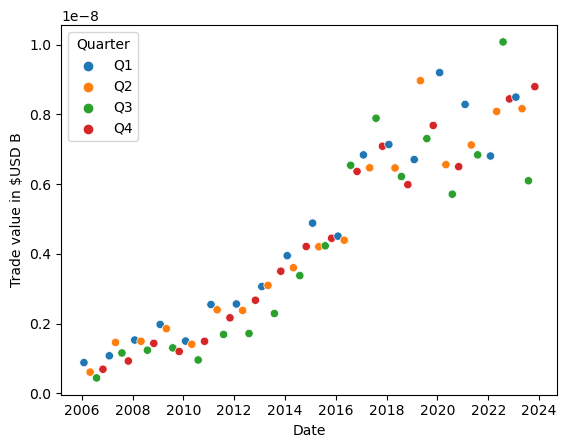

In [163]:
plt.figure()
sns.scatterplot(x = 'Time', y = 'Trade_Value', hue = "Quarter",
                data = sum_avocado)
plt.xlabel('Date')
plt.ylabel('Trade value in $USD B')
plt.show()

The plot shows a sharp decline in the sales exports for Q2 of 2024, it is clear that at the time of the data retrieval the quarter wasn't complete and therefore the value is not reliable. The value is an outlier and will be removed from future analysis.

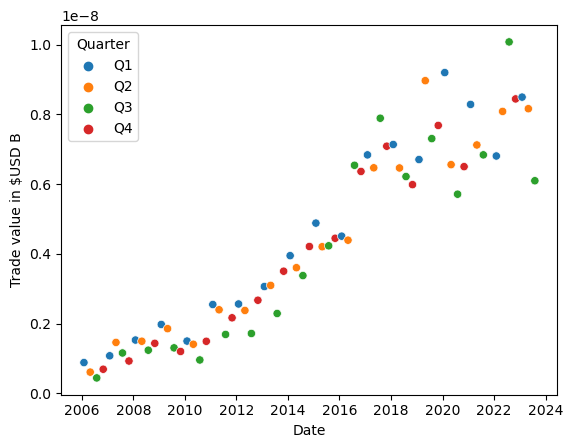

In [164]:
sum_avocado.drop(sum_avocado.tail(1).index,inplace = True)

plt.figure()
sns.scatterplot(x = 'Time', y = 'Trade_Value', hue = "Quarter",
                data = sum_avocado)
plt.xlabel('Date')
plt.ylabel('Trade value in $USD B')
plt.show()

Once the outlier year is removed, the overall trend of the sales rate is much more apparent: there is a steady growth of sales before 2016, afterwards there is a marked spike after 2016, with an increase in the sales and also the range of the variance increases. There is no clear tendency on wheter the quarter has a seasonal effect on the sales, to further analyze this we will perform a hypothesis testing.R:

## Hypothesis testing

The scatter plot of the avocado sales data was unclear on the seasonality of its nature. The hypothesis that there are more sales in any given quarter (regardless of the year) can be tested with a oneway ANOVA or analysis of variance.

In [128]:
from scipy.stats import f_oneway # import function for oneway ANOVA

In [160]:
# Subset the sales rates by quarter
q1 = sum_avocado[sum_avocado['Quarter']== 'Q1']['Trade_Value']
q2 = sum_avocado[sum_avocado['Quarter']== 'Q2']['Trade_Value']
q3 = sum_avocado[sum_avocado['Quarter']== 'Q3']['Trade_Value']
q4 = sum_avocado[sum_avocado['Quarter']== 'Q4']['Trade_Value']

In [161]:
anova_result = f_oneway(q1,q2,q3,q4) #perform the oneway analysis of variance on sales rate by quarter
print(anova_result)

F_onewayResult(statistic=0.05532655262926632, pvalue=0.9827315584040981)


In this case, the null hypothesis was that quarter has no impact on sales rate. Since the p-value is so high (much higher than the traditional cut-off of 0.05), the null hypothesis is accepted. The relatively low F statistic provides further support for our hypothesis. As a result, it can be concluded that the quarter does not impact the sales rate.

Now that the dataset is fully cleaned, it can be exported as a .csv file that will be used for causal inference in R:

In [159]:
sum_avocado.to_csv("avocado_cleaned.csv", index = False)

## Forcing variable

'Avocados from Mexico' was founded in 2013, nevertheless, their first major campaign was their ad in the SuperBowl XLIX, celebrated on February 1st, 2015. This will be considered the cutoff point of our RDD analysis, given that it marks the start of the impact of said organization in the mexican avocado trade.